In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

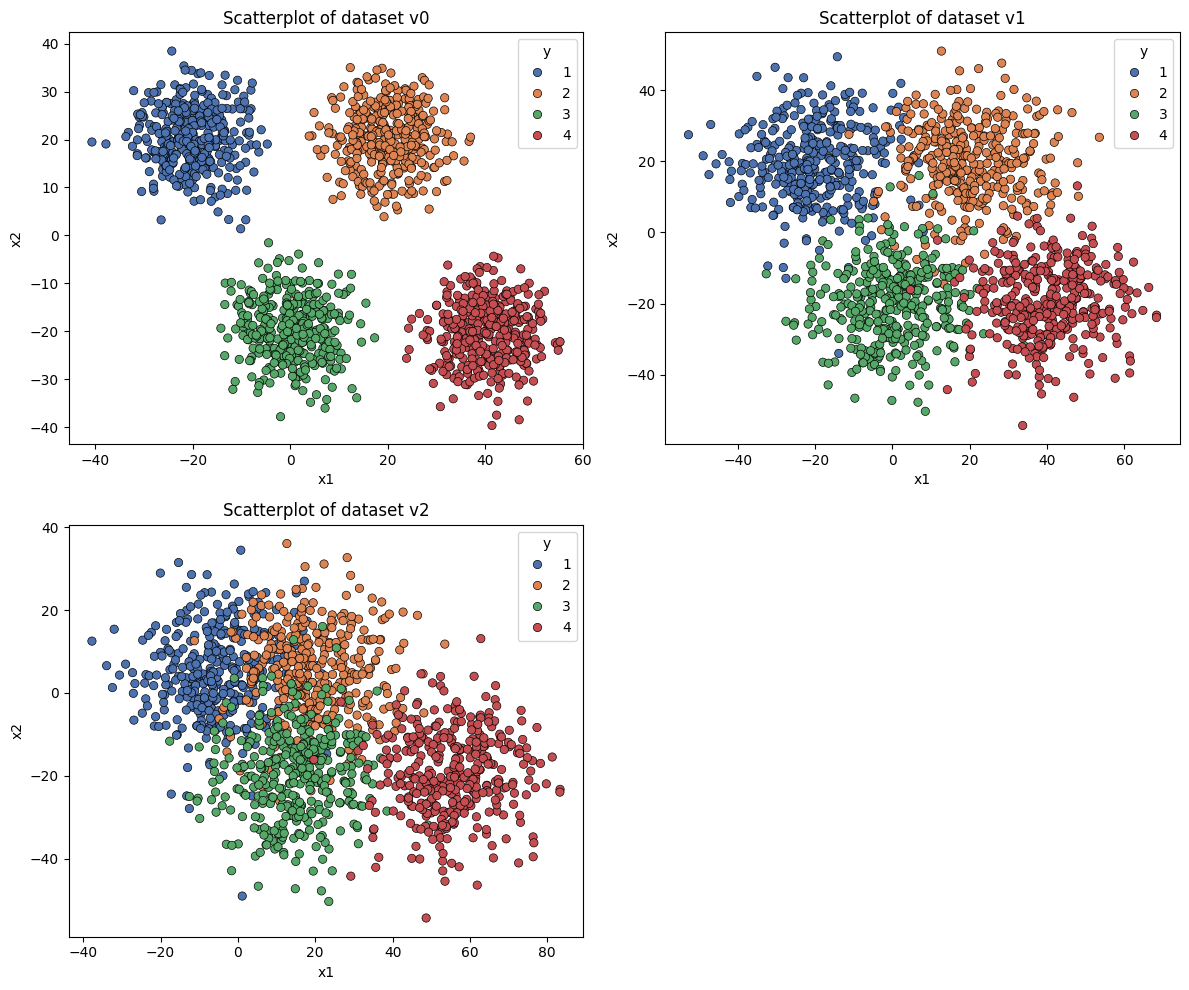

In [22]:
datasets = {
    "v0": pd.read_csv("Clusters-4-v0.csv"),
    "v1": pd.read_csv("Clusters-4-v1.csv"),
    "v2": pd.read_csv("Clusters-4-v2.csv"),
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

axes = axes.flatten()
for i, (name, df) in enumerate(datasets.items()):
    ax = axes[i]  # Get the current subplot
    sns.scatterplot(
        x=df.iloc[:, 0],
        y=df.iloc[:, 1],
        hue=df["y"],
        palette="deep",
        edgecolor="k",
        ax=ax 
    )
    ax.set_title(f"Scatterplot of dataset {name}")

if len(datasets) < len(axes):
    for i in range(len(datasets), len(axes)):
        axes[i].axis('off')

# Adjust layout to prevent titles from overlapping
plt.tight_layout()
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
splits = {}

for name, df in datasets.items():
    X = df.drop("y", axis=1).values   # features
    y = df["y"].values               # target labels
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    splits[name] = (X_train, X_test, y_train, y_test)
    
    print(f"\nDataset {name}:")
    print(f"  Train size: {X_train.shape}, Test size: {X_test.shape}")


Dataset v0:
  Train size: (1008, 2), Test size: (432, 2)

Dataset v1:
  Train size: (1008, 2), Test size: (432, 2)

Dataset v2:
  Train size: (1008, 2), Test size: (432, 2)


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, auc)

results = []

def evaluate_model(model, X_train, X_test, y_train, y_test, algo_name, dataset_name):
    """Train model, predict, and collect metrics for train and test sets."""
    print(f"Training {algo_name} on dataset {dataset_name}...")
    model.fit(X_train, y_train)
    print(f"Completed {algo_name} on dataset {dataset_name}")
    
    for split, X, y in [("train", X_train, y_train), ("test", X_test, y_test)]:
        y_pred = model.predict(X)
        
        # handle probability/decision scores
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X)
        else:
            y_score = model.decision_function(X)
        
        metrics = {
            "dataset": dataset_name,
            "algorithm": algo_name,
            "split": split,
            "accuracy": accuracy_score(y, y_pred),
            "precision": precision_score(y, y_pred, average="macro"),
            "recall": recall_score(y, y_pred, average="macro"),
            "f1": f1_score(y, y_pred, average="macro"),
            "auc": roc_auc_score(pd.get_dummies(y), y_score, multi_class="ovr")
        }
        results.append(metrics)

# ------------------------------
# Run all models on all datasets
# ------------------------------
for dataset_name, (X_train, X_test, y_train, y_test) in splits.items():
    print(f"\n==============================")
    print(f"Starting models for dataset {dataset_name}")
    print(f"==============================")
    
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    # Logistic Regression
    evaluate_model(LogisticRegression(max_iter=500, random_state=42),
                   X_train_s, X_test_s, y_train, y_test, 
                   "Logistic Regression", dataset_name)
    
    # Logistic Regression + Polynomial
    poly = Pipeline([
        ("poly", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(max_iter=500, random_state=42))
    ])
    evaluate_model(poly, X_train, X_test, y_train, y_test,
                   "Logistic Regression + Poly", dataset_name)
    
    # SVC Linear
    evaluate_model(SVC(kernel="linear", probability=True, random_state=42),
                   X_train_s, X_test_s, y_train, y_test,
                   "SVC (linear)", dataset_name)
    
    # SVC RBF
    evaluate_model(SVC(kernel="rbf", probability=True, random_state=42),
                   X_train_s, X_test_s, y_train, y_test,
                   "SVC (rbf)", dataset_name)
    
    # Random Forest (grid search style)
    for min_samples in [1, 3, 5]:
        for depth in [2, 3, 5]:
            rf = RandomForestClassifier(
                min_samples_leaf=min_samples,
                max_depth=depth,
                random_state=42
            )
            algo_name = f"RandomForest(leaf={min_samples}, depth={depth})"
            evaluate_model(rf, X_train, X_test, y_train, y_test,
                           algo_name, dataset_name)
    
    # Neural Networks
    for layers in [(5,), (5,5), (5,5,5), (10,)]:
        nn = MLPClassifier(hidden_layer_sizes=layers, max_iter=1000, random_state=42)
        algo_name = f"NeuralNet{layers}"
        evaluate_model(nn, X_train_s, X_test_s, y_train, y_test,
                       algo_name, dataset_name)

# ------------------------------
# Save results
# ------------------------------
results_df = pd.DataFrame(results)
results_df.to_csv("all_model_results.csv", index=False)
print("\n Saved results to all_model_results.csv")



Starting models for dataset v0
Training Logistic Regression on dataset v0...
Completed Logistic Regression on dataset v0
Training Logistic Regression + Poly on dataset v0...
Completed Logistic Regression + Poly on dataset v0
Training SVC (linear) on dataset v0...
Completed SVC (linear) on dataset v0
Training SVC (rbf) on dataset v0...
Completed SVC (rbf) on dataset v0
Training RandomForest(leaf=1, depth=2) on dataset v0...
Completed RandomForest(leaf=1, depth=2) on dataset v0
Training RandomForest(leaf=1, depth=3) on dataset v0...
Completed RandomForest(leaf=1, depth=3) on dataset v0
Training RandomForest(leaf=1, depth=5) on dataset v0...
Completed RandomForest(leaf=1, depth=5) on dataset v0
Training RandomForest(leaf=3, depth=2) on dataset v0...
Completed RandomForest(leaf=3, depth=2) on dataset v0
Training RandomForest(leaf=3, depth=3) on dataset v0...
Completed RandomForest(leaf=3, depth=3) on dataset v0
Training RandomForest(leaf=3, depth=5) on dataset v0...
Completed RandomForest

Training Logistic Regression on v0...
Completed Logistic Regression on v0
Training SVC (RBF Kernel) on v0...
Completed SVC (RBF Kernel) on v0
Training Random Forest on v0...
Completed Random Forest on v0
Training Neural Network (5,) on v0...
Completed Neural Network (5,) on v0
Training Neural Network (5,5) on v0...
Completed Neural Network (5,5) on v0
Training Neural Network (5,5,5) on v0...
Completed Neural Network (5,5,5) on v0
Training Neural Network (10,) on v0...
Completed Neural Network (10,) on v0


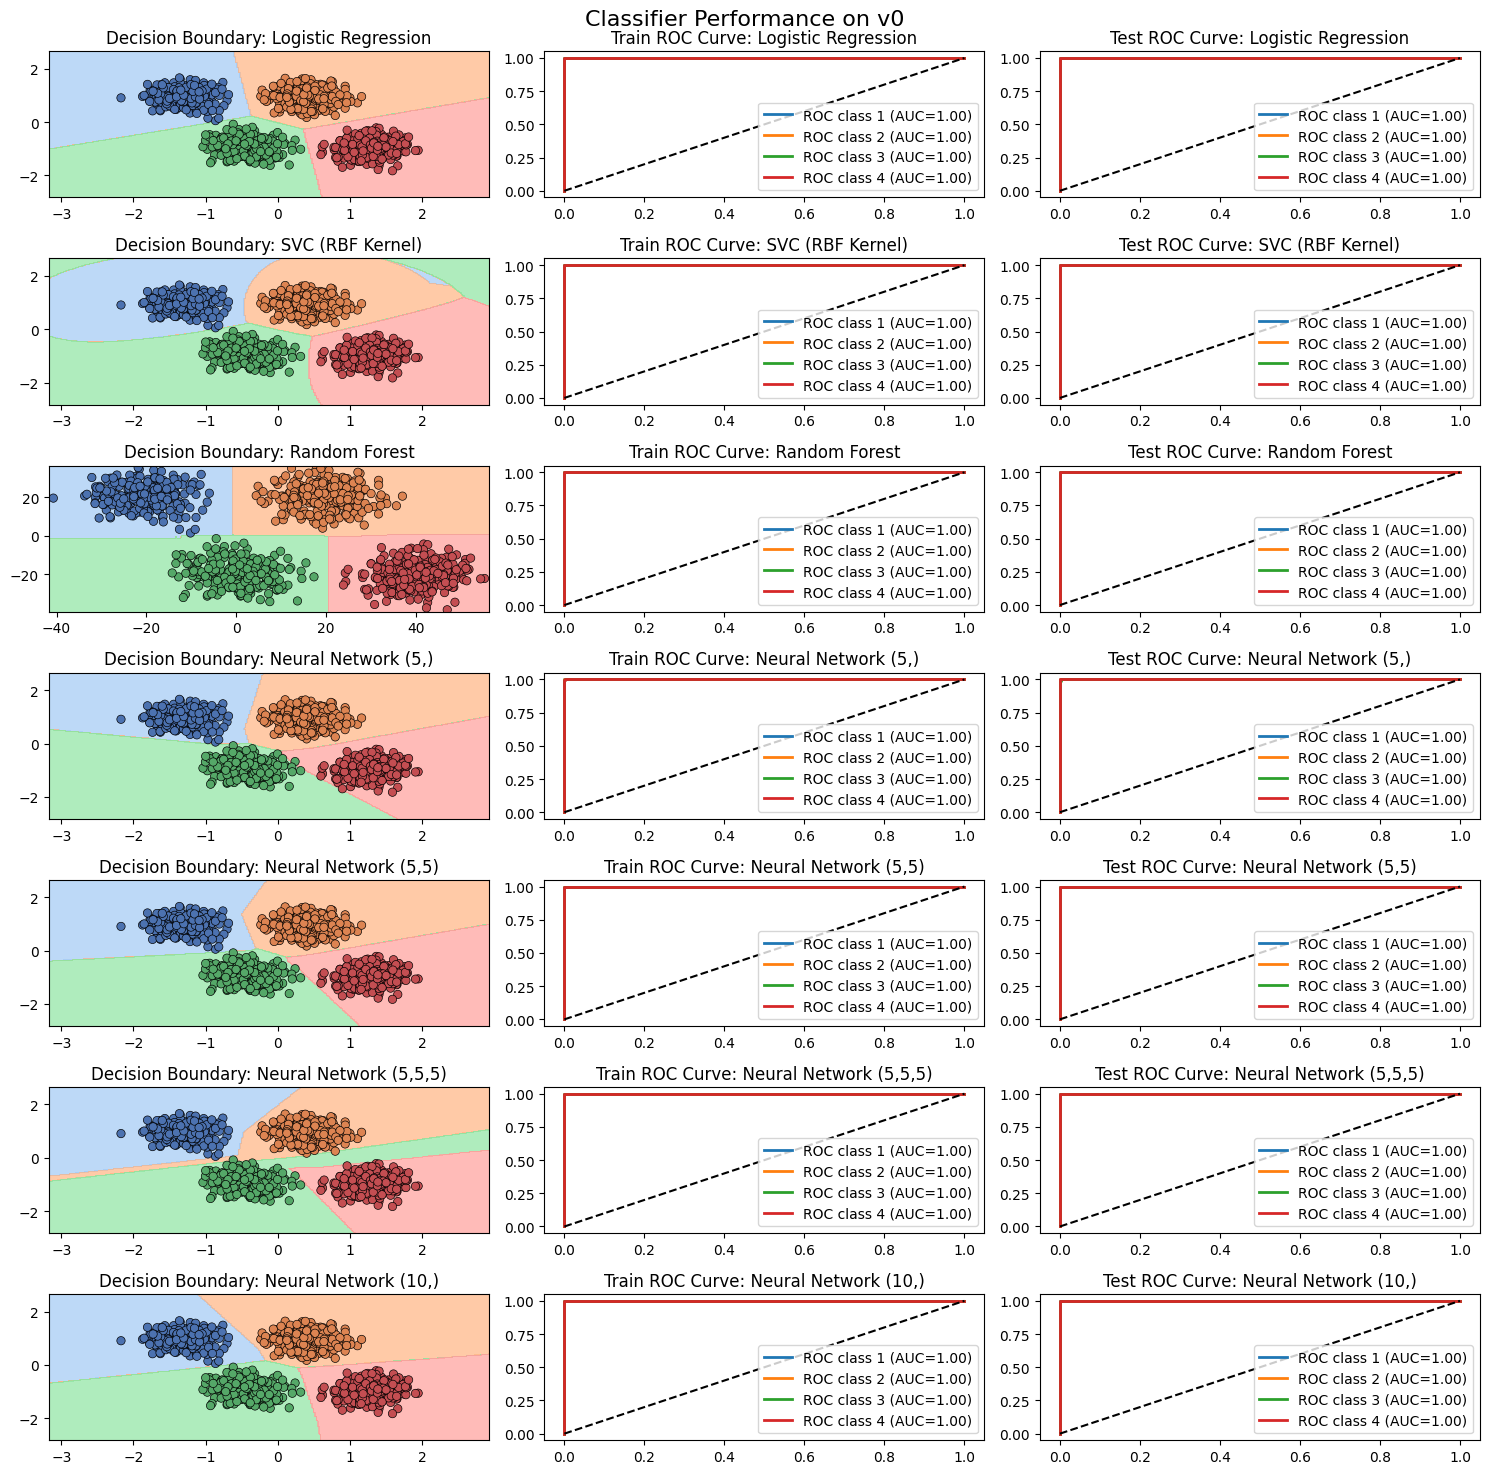

Saved plot for v0 as classifier_performance_v0.png
Training Logistic Regression on v1...
Completed Logistic Regression on v1
Training SVC (RBF Kernel) on v1...
Completed SVC (RBF Kernel) on v1
Training Random Forest on v1...
Completed Random Forest on v1
Training Neural Network (5,) on v1...
Completed Neural Network (5,) on v1
Training Neural Network (5,5) on v1...
Completed Neural Network (5,5) on v1
Training Neural Network (5,5,5) on v1...
Completed Neural Network (5,5,5) on v1
Training Neural Network (10,) on v1...
Completed Neural Network (10,) on v1


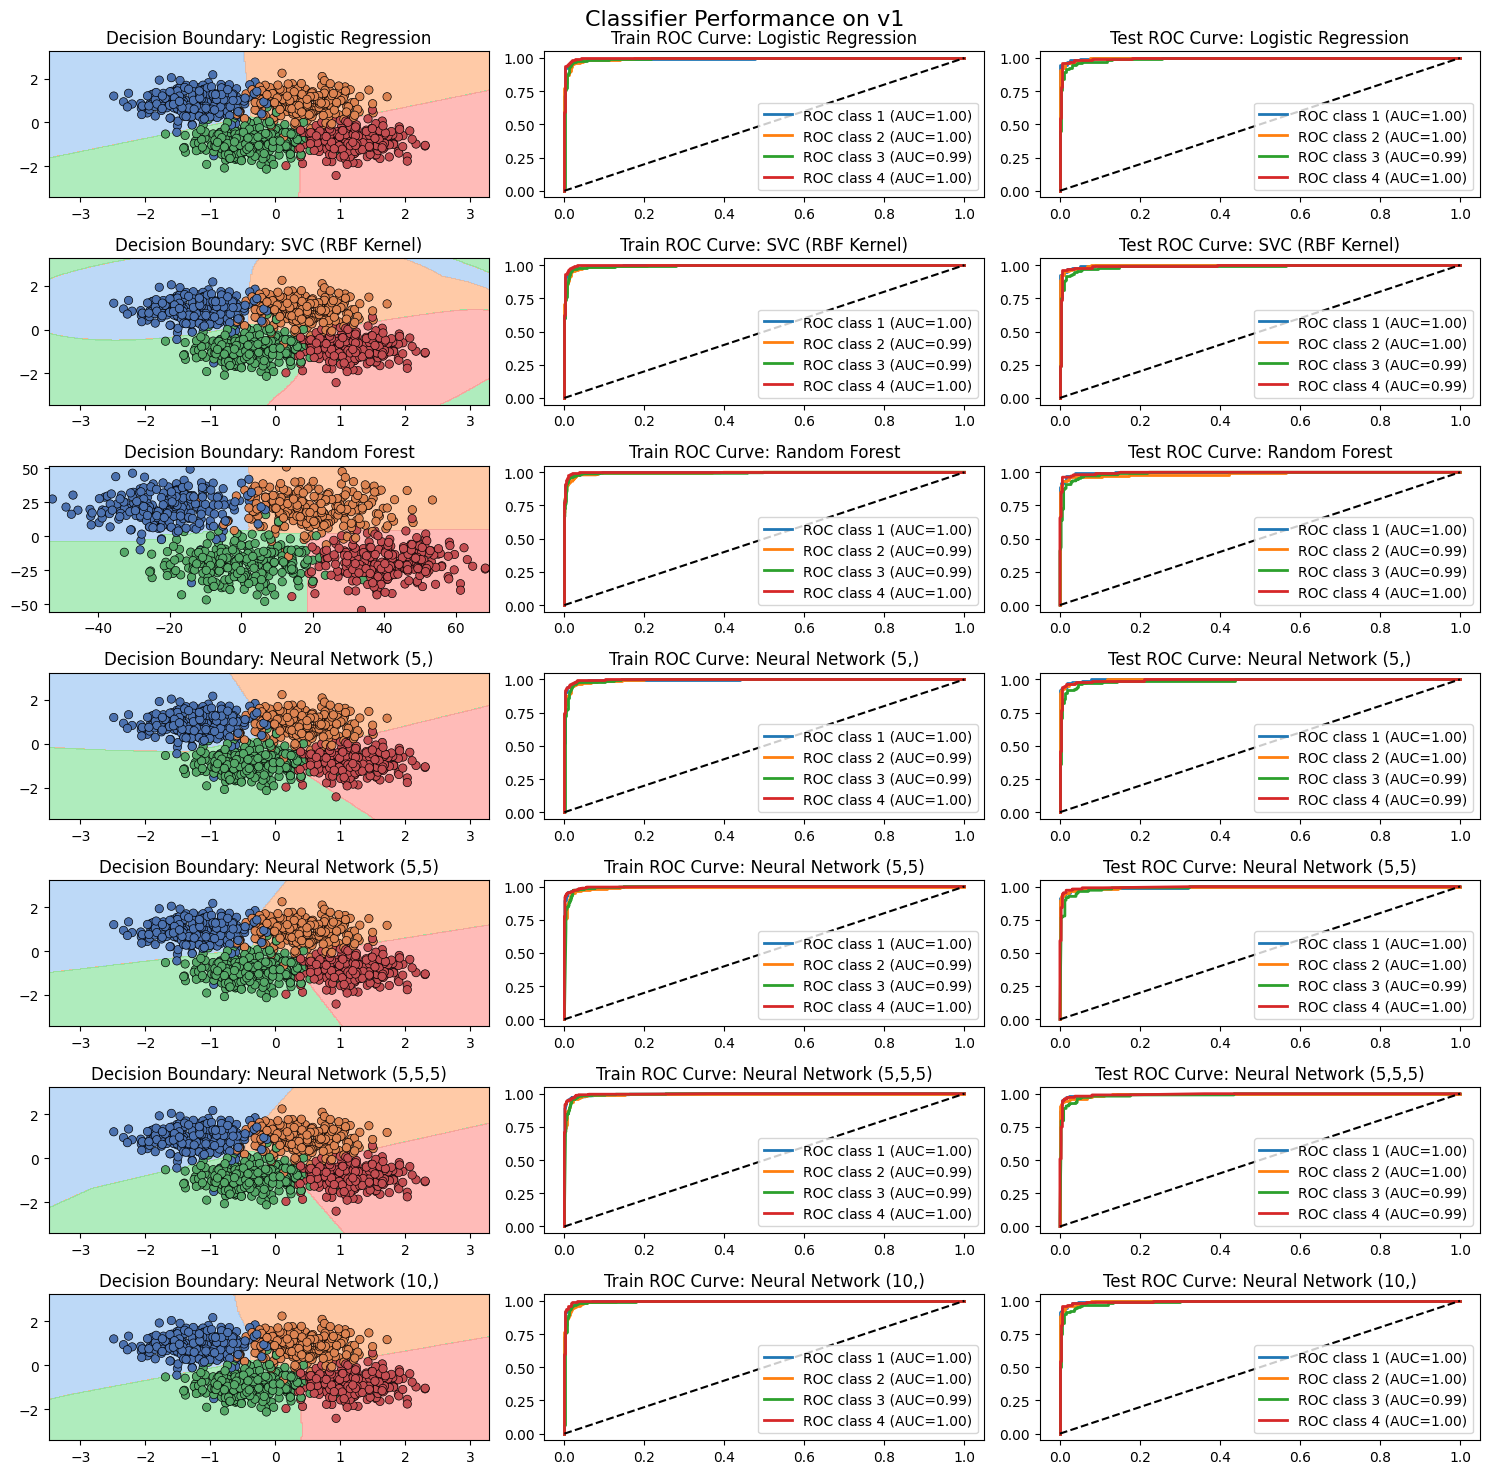

Saved plot for v1 as classifier_performance_v1.png
Training Logistic Regression on v2...
Completed Logistic Regression on v2
Training SVC (RBF Kernel) on v2...
Completed SVC (RBF Kernel) on v2
Training Random Forest on v2...
Completed Random Forest on v2
Training Neural Network (5,) on v2...
Completed Neural Network (5,) on v2
Training Neural Network (5,5) on v2...
Completed Neural Network (5,5) on v2
Training Neural Network (5,5,5) on v2...
Completed Neural Network (5,5,5) on v2
Training Neural Network (10,) on v2...
Completed Neural Network (10,) on v2


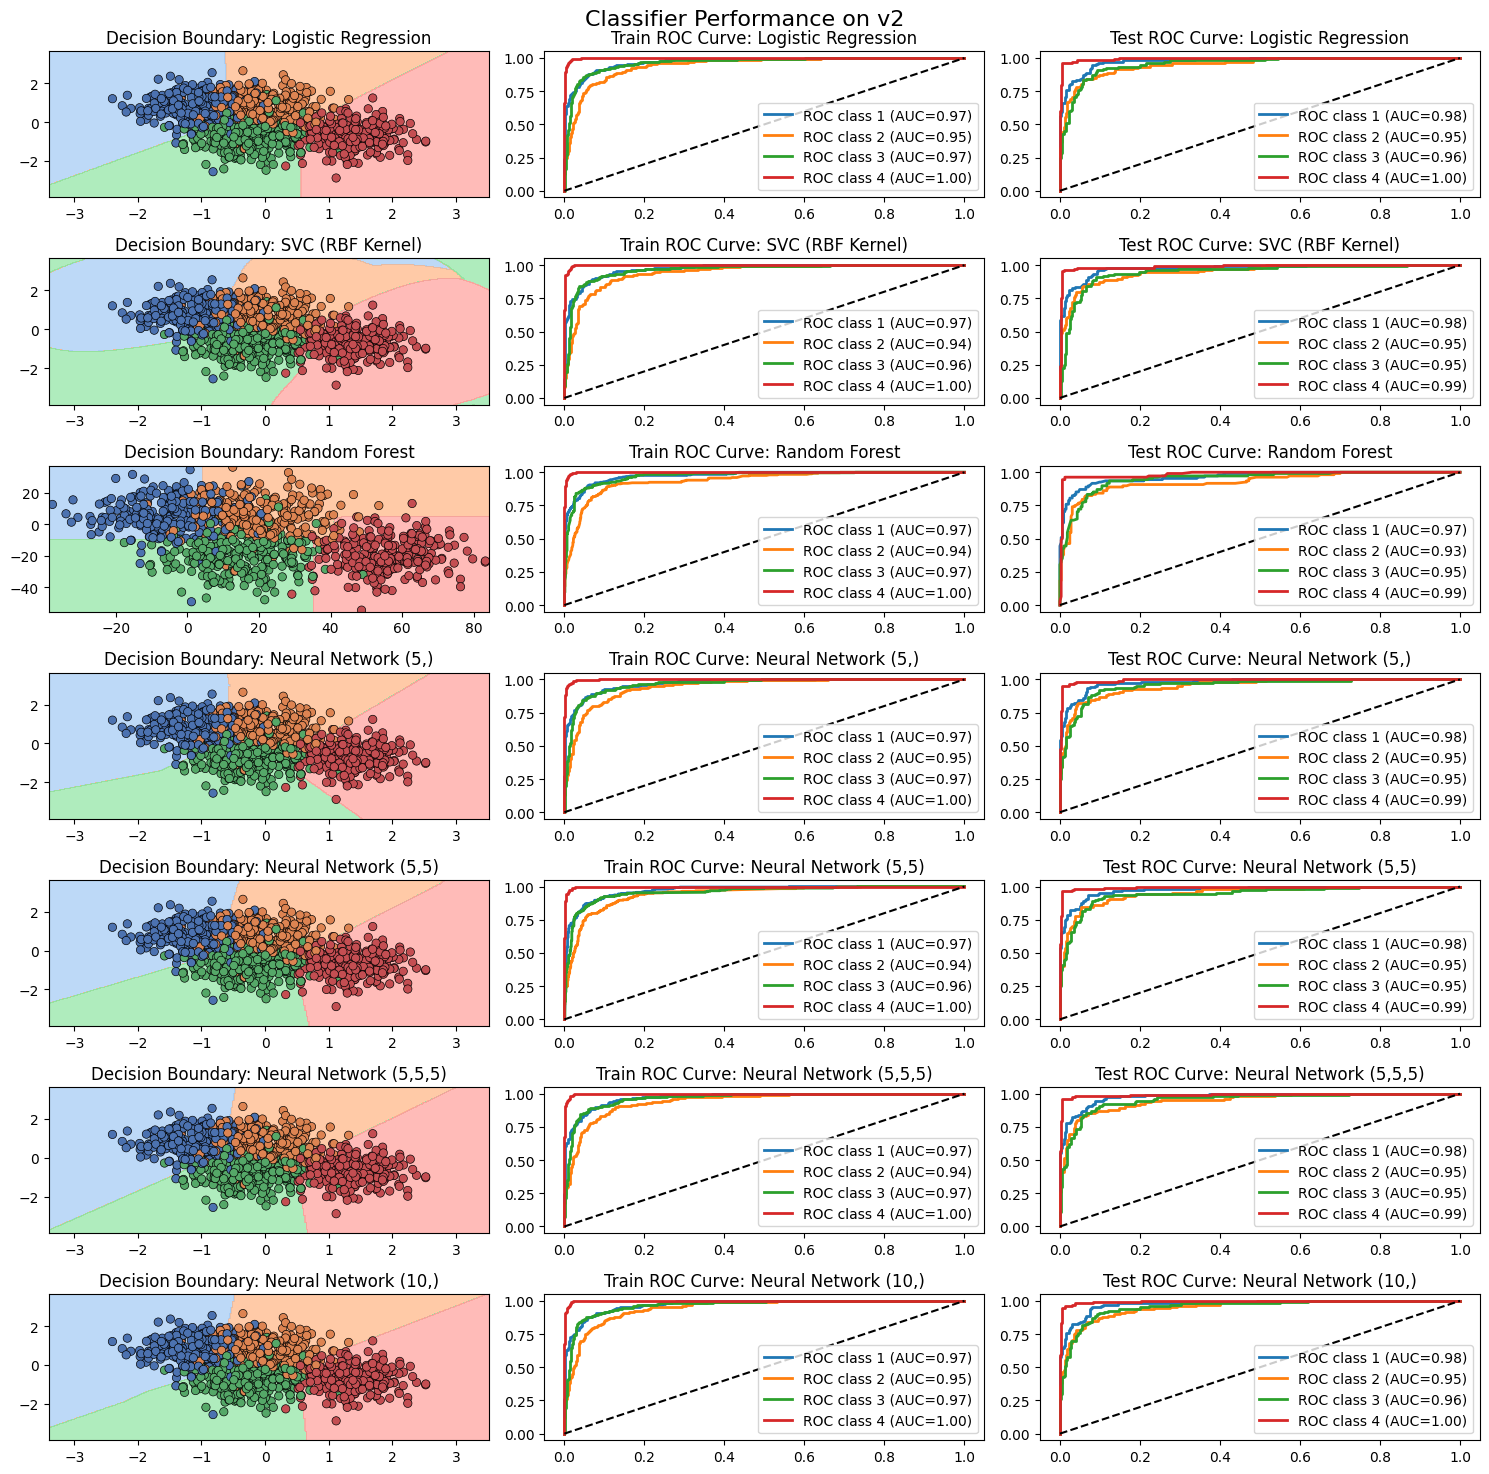

Saved plot for v2 as classifier_performance_v2.png


In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import numpy as np

def plot_classifier_performance(X_train, X_test, y_train, y_test, dataset_name):
    classifiers = {
        "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
        "SVC (RBF Kernel)": SVC(kernel="rbf", probability=True, random_state=42),
        "Random Forest": RandomForestClassifier(max_depth=3, random_state=42),
        "Neural Network (5,)": MLPClassifier(hidden_layer_sizes=(5), max_iter=1000, random_state=42),
        "Neural Network (5,5)": MLPClassifier(hidden_layer_sizes=(5,5), max_iter=1000, random_state=42),
        "Neural Network (5,5,5)": MLPClassifier(hidden_layer_sizes=(5,5,5), max_iter=1000, random_state=42),
        "Neural Network (10,)": MLPClassifier(hidden_layer_sizes=(10), max_iter=1000, random_state=42),
    }
    
    # Scale inputs for LR, SVC, NN
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    fig, axes = plt.subplots(len(classifiers), 3, figsize=(15, 15))
    fig.suptitle(f"Classifier Performance on {dataset_name}", fontsize=16)
    
    for idx, (name, clf) in enumerate(classifiers.items()):
        # Pick scaled features for appropriate models
        if "Random Forest" in name:
            Xtr, Xte = X_train, X_test
        else:
            Xtr, Xte = X_train_s, X_test_s
        
        # Train
        print(f"Training {name} on {dataset_name}...")
        clf.fit(Xtr, y_train)
        print(f"Completed {name} on {dataset_name}")
        
        # ---- Left: Decision Boundary ----
        ax = axes[idx, 0]
        h = .02
        x_min, x_max = Xtr[:, 0].min() - 1, Xtr[:, 0].max() + 1
        y_min, y_max = Xtr[:, 1].min() - 1, Xtr[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        cmap_light = ListedColormap(sns.color_palette("pastel", len(np.unique(y_train))))
        cmap_bold = ListedColormap(sns.color_palette("deep", len(np.unique(y_train))))
        ax.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.7)
        sns.scatterplot(x=Xtr[:,0], y=Xtr[:,1], hue=y_train,
                        palette=cmap_bold, edgecolor="k", ax=ax, legend=False)
        ax.set_title(f"Decision Boundary: {name}")
        
        # ---- Middle: Train ROC ----
        ax = axes[idx, 1]
        if hasattr(clf, "predict_proba"):
            y_score = clf.predict_proba(Xtr)
        else:
            y_score = clf.decision_function(Xtr)
        
        classes = np.unique(y_train)
        for j, c in enumerate(classes):   # j = column index, c = class label
            if np.sum(y_train == c) == 0:  # skip if class missing
                continue
            fpr, tpr, _ = roc_curve((y_train == c).astype(int), y_score[:, j])
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, lw=2, label=f"ROC class {c} (AUC={roc_auc:.2f})")
        ax.plot([0, 1], [0, 1], "k--")
        ax.set_title(f"Train ROC Curve: {name}")
        ax.legend(loc="lower right")
        
        # ---- Right: Test ROC ----
        ax = axes[idx, 2]
        if hasattr(clf, "predict_proba"):
            y_score = clf.predict_proba(Xte)
        else:
            y_score = clf.decision_function(Xte)
        
        classes = np.unique(y_test)
        for j, c in enumerate(classes):
            if np.sum(y_test == c) == 0:  # skip if class missing
                continue
            fpr, tpr, _ = roc_curve((y_test == c).astype(int), y_score[:, j])
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, lw=2, label=f"ROC class {c} (AUC={roc_auc:.2f})")
        ax.plot([0, 1], [0, 1], "k--")
        ax.set_title(f"Test ROC Curve: {name}")
        ax.legend(loc="lower right")
        
    plt.tight_layout()
    plt.show()
    # Optional: save for report
    fig.savefig(f"classifier_performance_{dataset_name}.png", dpi=200)
    print(f"Saved plot for {dataset_name} as classifier_performance_{dataset_name}.png")

# -----------------
# Run for all datasets
# -----------------
for name, (X_train, X_test, y_train, y_test) in splits.items():
    plot_classifier_performance(X_train, X_test, y_train, y_test, name)


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_models(X_train, X_test, y_train, y_test, dataset_name):
    classifiers = {
        "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
        "SVC (RBF Kernel)": SVC(kernel="rbf", probability=True, random_state=42),
        "Random Forest": RandomForestClassifier(max_depth=3, random_state=42),
        "Neural Network (5,)": MLPClassifier(hidden_layer_sizes=(5), max_iter=1000, random_state=42),
        "Neural Network (5,5)": MLPClassifier(hidden_layer_sizes=(5,5), max_iter=1000, random_state=42),
        "Neural Network (5,5,5)": MLPClassifier(hidden_layer_sizes=(5,5,5), max_iter=1000, random_state=42),
        "Neural Network (10,)": MLPClassifier(hidden_layer_sizes=(10), max_iter=1000, random_state=42),
    }

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    results = []

    for name, clf in classifiers.items():
        if "Random Forest" in name:
            Xtr, Xte = X_train, X_test
        else:
            Xtr, Xte = X_train_s, X_test_s

        clf.fit(Xtr, y_train)
        y_pred = clf.predict(Xte)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
        rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

        results.append([dataset_name, name, acc, prec, rec, f1])

    return results

all_results = []
for name, (X_train, X_test, y_train, y_test) in splits.items():
    all_results.extend(evaluate_models(X_train, X_test, y_train, y_test, name))

import pandas as pd
results_df = pd.DataFrame(all_results, columns=["Dataset", "Classifier", "Accuracy", "Precision", "Recall", "F1"])
display(results_df)

Dataset              Classifier  Accuracy  Precision    Recall        F1
0       v0     Logistic Regression  1.000000   1.000000  1.000000  1.000000
1       v0        SVC (RBF Kernel)  1.000000   1.000000  1.000000  1.000000
2       v0           Random Forest  1.000000   1.000000  1.000000  1.000000
3       v0     Neural Network (5,)  0.997685   0.997706  0.997685  0.997685
4       v0    Neural Network (5,5)  1.000000   1.000000  1.000000  1.000000
5       v0  Neural Network (5,5,5)  1.000000   1.000000  1.000000  1.000000
6       v0    Neural Network (10,)  1.000000   1.000000  1.000000  1.000000
7       v1     Logistic Regression  0.946759   0.947761  0.946759  0.947019
8       v1        SVC (RBF Kernel)  0.944444   0.946108  0.944444  0.944870
9       v1           Random Forest  0.939815   0.942289  0.939815  0.940269
10      v1     Neural Network (5,)  0.939815   0.941182  0.939815  0.940197
11      v1    Neural Network (5,5)  0.946759   0.948235  0.946759  0.947116
12      v1  Neural Network (5,5,5)  0.946759   0.948464  0.946759  0.947183
13      v1    Neural Network (10,)  0.946759   0.947761  0.946759  0.947019
14      v2     Logistic Regression  0.868056   0.869878  0.868056  0.868191
15      v2        SVC (RBF Kernel)  0.863426   0.865947  0.863426  0.863917
16      v2           Random Forest  0.851852   0.856091  0.851852  0.852534
17      v2     Neural Network (5,)  0.861111   0.862085  0.861111  0.861453
18      v2    Neural Network (5,5)  0.861111   0.860511  0.861111  0.860671
19      v2  Neural Network (5,5,5)  0.865741   0.867979  0.865741  0.866362
20      v2    Neural Network (10,)  0.870370   0.872329  0.870370  0.870572

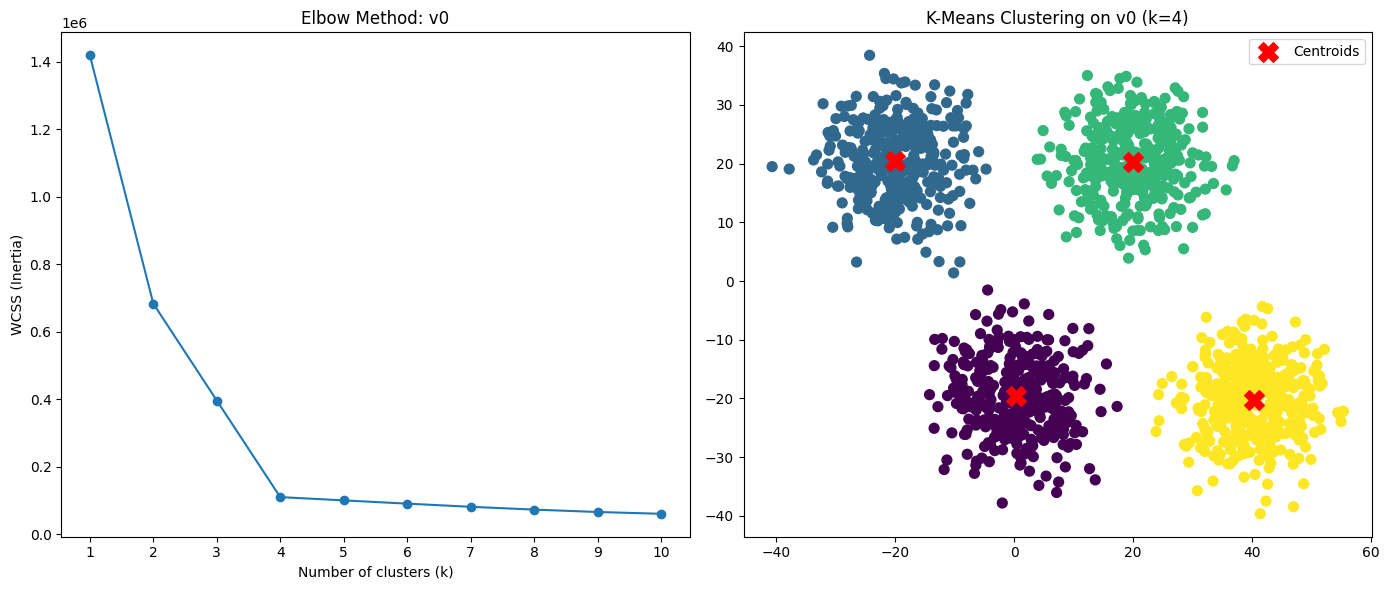

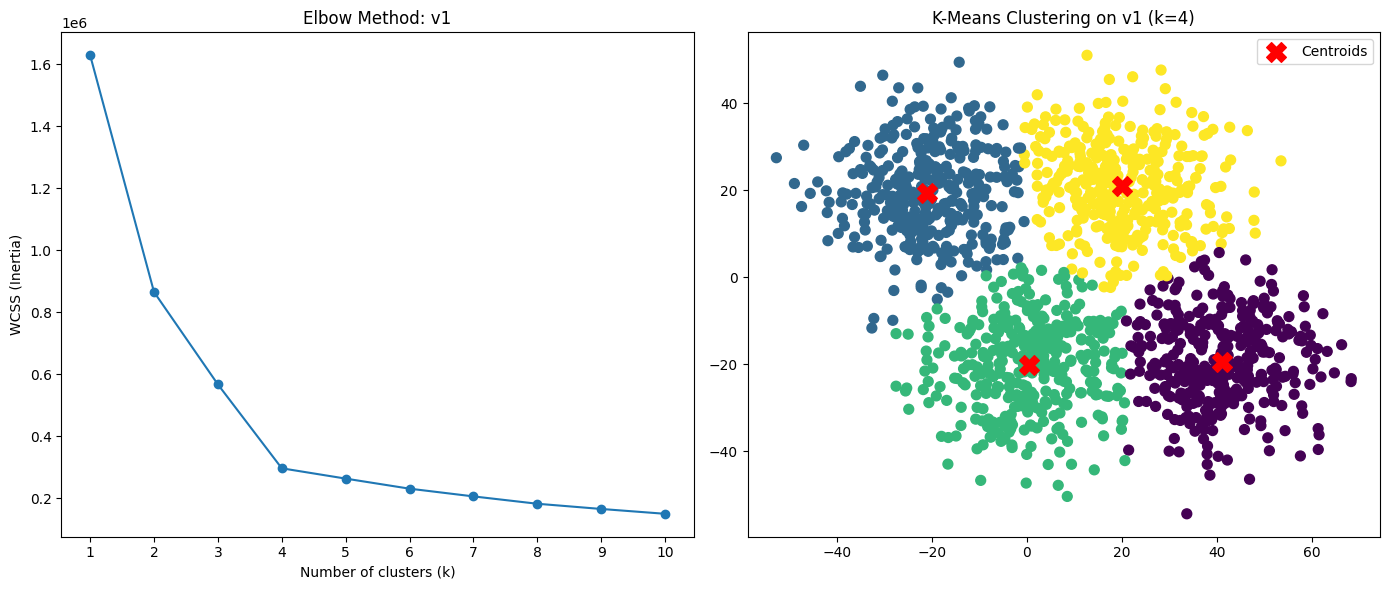

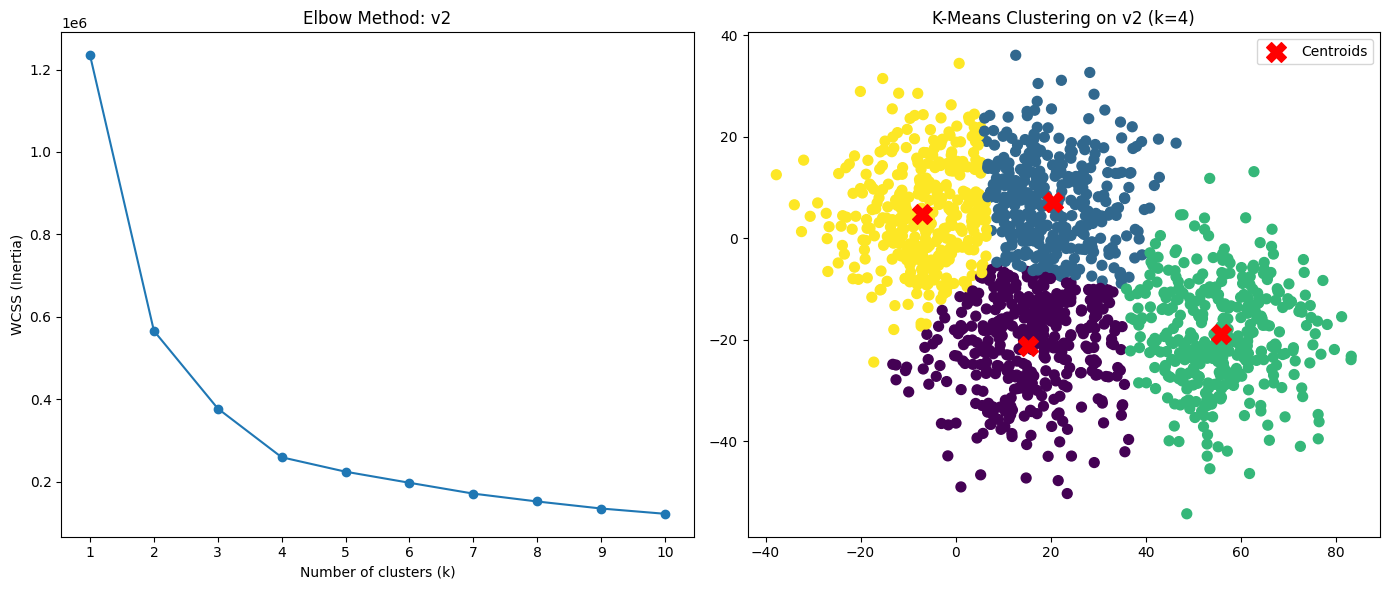

In [21]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

datasets = {
    "v0": pd.read_csv("Clusters-4-v0.csv"),
    "v1": pd.read_csv("Clusters-4-v1.csv"),
    "v2": pd.read_csv("Clusters-4-v2.csv"),
}

for name, df in datasets.items():
    X = df.iloc[:, :2].values  
    
    wcss = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=100)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    
    k_opt = 4
    kmeans = KMeans(n_clusters=k_opt, init='k-means++', n_init=10, random_state=100)
    clusters = kmeans.fit_predict(X)
    df["Cluster"] = clusters
    
    fig, axs = plt.subplots(1, 2, figsize=(14,6))
    
    # Elbow plot
    axs[0].plot(range(1, 11), wcss, marker='o')
    axs[0].set_title(f"Elbow Method: {name}")
    axs[0].set_xlabel("Number of clusters (k)")
    axs[0].set_ylabel("WCSS (Inertia)")
    axs[0].set_xticks(range(1,11))
    
    # Clustering plot
    scatter = axs[1].scatter(X[:,0], X[:,1], c=clusters, cmap="viridis", s=50)
    axs[1].scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
                   c="red", marker="X", s=200, label="Centroids")
    axs[1].set_title(f"K-Means Clustering on {name} (k={k_opt})")
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()
